In [70]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix as cm
import sklearn.metrics as skm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

from xgboost import XGBRegressor
import xgboost as xgb

In [52]:
pd.set_option('display.max_columns', None)

In [63]:
# Load Data

# Load train and test sets
train_df = pd.read_csv("Data/train.csv")
test_df  = pd.read_csv("Data/test.csv")

# Separate target and features
y = train_df["SalePrice"]
X = train_df.drop("SalePrice", axis=1)

# Keep test features
X_test_final = test_df.copy()

print(X.shape, X_test_final.shape)


(1460, 80) (1459, 80)


### Data Pre-processing

##### 1. Distribution of Target Variable

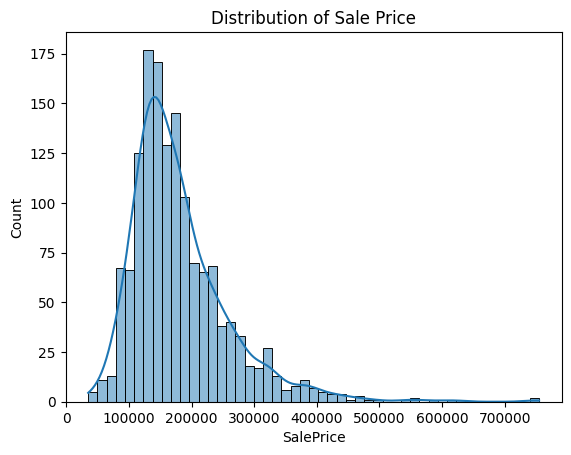

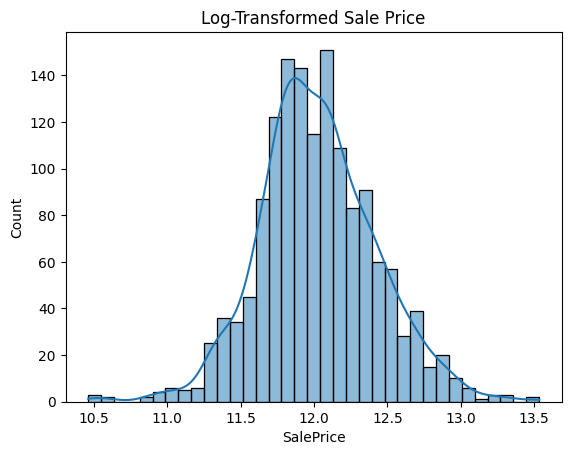

In [64]:
sns.histplot(train_df['SalePrice'], kde=True)
plt.title("Distribution of Sale Price")
plt.show()

# Log-transform check (As Sale Price is skewed)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True)
plt.title("Log-Transformed Sale Price")
plt.show()


##### 2. Correlation Analysis

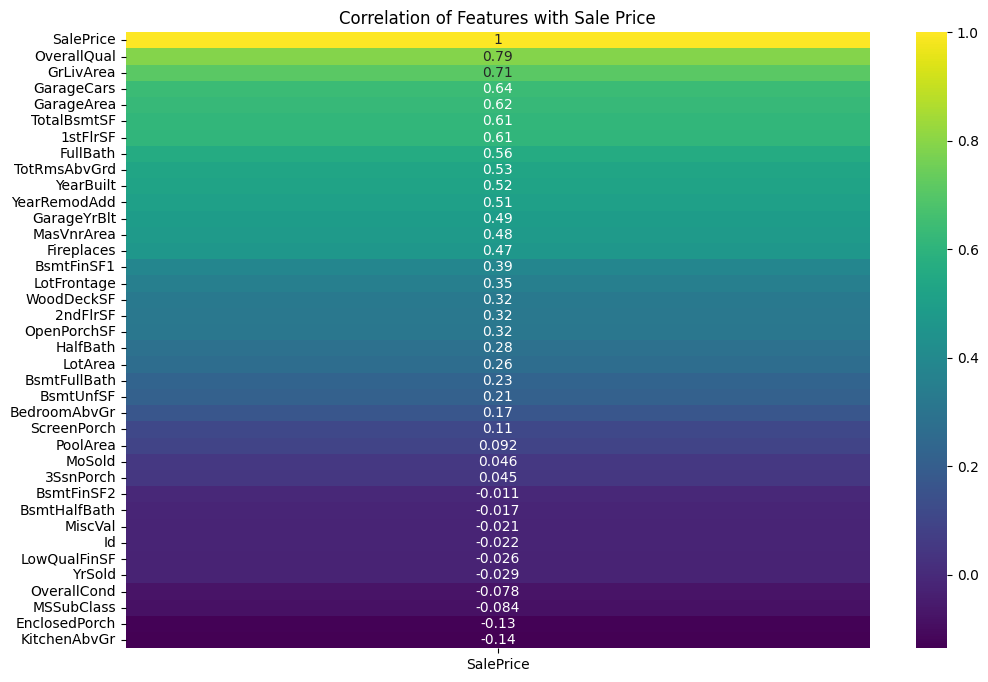

In [65]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap="viridis")
plt.title("Correlation of Features with Sale Price")
plt.show()


##### 3. Identify Column Types

In [66]:
# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 37
Categorical features: 43


##### 4. Transformers

In [67]:
# Numeric Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing with median
    ("scaler", StandardScaler())                   # Normalize features
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),   # Fill missing with most common
    ("encoder", OneHotEncoder(handle_unknown="ignore"))     # One-hot encode categories
])
# Combine both pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### Model Building

In [69]:
# Model Pipeline

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", rfr(
        n_estimators=200, random_state=42, n_jobs=-1
    ))
])


In [ ]:
#Train/Validate Split

X_train, X_valid, y_train, y_valid = tts(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# Validate
y_pred = model.predict(X_valid)
rmse = np.sqrt(mse(y_valid, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 28496.787082143084


In [72]:
# Final Data Preparation

# Train on full training data
model.fit(X, y)

# Predict on test set
test_preds = model.predict(X_test_final)

# Save submission file
submission = pd.DataFrame({
    "Id": X_test_final["Id"],
    "SalePrice": test_preds
})
submission.to_csv("submission.csv", index=False)
